In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os import path
import os

# Classifiers
from sklearn.naive_bayes import GaussianNB # Gaussiana de Naive-Bayes
from sklearn.neural_network import MLPClassifier # Multi-layer Perceptron
from sklearn.neighbors import KNeighborsClassifier # K-Nearest Neighbors
from sklearn.tree import DecisionTreeClassifier # Decision Tree
from sklearn.ensemble import RandomForestClassifier # Random Forest
from sklearn.ensemble import AdaBoostClassifier # AdaBoost
from sklearn.svm import SVC # Support Vector Machine (Linear, Polynomial, RBF)

# Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score
from imblearn.metrics import sensitivity_score
from imblearn.metrics import specificity_score
from sklearn.metrics import f1_score

from sklearn.metrics import confusion_matrix

## Classification of datasets

In [7]:
EXPERIMENT_NAME = "Empty_Classification"

# Set datasets to classification: ['Raw', 'Normalized', 'Fourier', 'HOS', 'SCM']
datasets_name_list = ['Fourier', 'HOS', 'SCM']

# Set classifiers to classification: ['Naive_Bayes','MLP','Nearest_Neighbors','Random_Forest','SVM_Linear','SVM_Polynomial','SVM_RBF']
classifiers_name_list = ['Naive_Bayes','MLP','Nearest_Neighbors','Random_Forest','SVM_Linear','SVM_Polynomial','SVM_RBF']

# Set metrics to evaluate classifier performance: ['accuracy','balanced_accuracy','precision','sensitivity','specificity','f1_score','fit_time','predict_time']
metrics_name_list = ['accuracy','balanced_accuracy','precision','sensitivity','specificity','f1_score','fit_time','predict_time']

# Set classes to classification: 3225 = CLASS 0, 3225_REVERSO = CLASS 1, 3225_VAZIO = CLASS 2, 3230 = CLASS 3, 3230_VAZIO = CLASS 4, 3235 = CLASS 5
classes = [0, 2, 3, 4]

# Grouping classes
group_classes = True

# Define the grouping, if it is True
if group_classes:
    changeClass_dict = {0:1, 2:0, 3:1, 4:0} # format {old:new, old:new,...}

# Making dirs to save results
outpath = path.join("..","results","classification",EXPERIMENT_NAME)
os.makedirs(outpath)

for ds_name in datasets_name_list:
    os.makedirs(path.join(outpath, ds_name))
    
def join_classes(df, dict_groups):
    df['Class'].replace(dict_groups, inplace=True)
    return df

FileExistsError: [Errno 17] File exists: '../results/classification/Empty_Classification'

In [65]:
# Load datasets
datasets_list = []

if 'Raw' in datasets_name_list:
    RawDs = pd.read_csv(path.join("..","results","extraction","32FINAL.csv"))
    RawDs = RawDs.drop(columns=['Tmp'+str(i) for i in range(100)]) # Exclude Tmp columns
    datasets_list.append(RawDs)
    
if 'Normalized' in datasets_name_list:
    NormDs = pd.read_csv(path.join("..","results","extraction","32FINAL_NORM.csv"))
    NormDs = NormDs.drop(columns=['Tmp'+str(i) for i in range(100)]) # Exclude Tmp columns
    datasets_list.append(NormDs)
    
if 'Fourier' in datasets_name_list:
    FourierDs = pd.read_csv(path.join("..","results","extraction","32FINAL_Fourier.csv"))
    datasets_list.append(FourierDs)
    
if 'HOS' in datasets_name_list:
    HOSDs = pd.read_csv(path.join("..","results","extraction","32FINAL_HOS.csv"))
    datasets_list.append(HOSDs)
    
if 'SCM' in datasets_name_list:
    SCMDs = pd.read_csv(path.join("..","results","extraction","32FINAL_SCM.csv"))
    datasets_list.append(SCMDs)

# Exclude classes that are not in scope 
for ds in datasets_list:
    for i in range(6):
        if i not in classes:
            indexNames = ds[ds['Class'] == i].index
            ds.drop(indexNames, inplace=True) # Delete these row indexes from dataframe

# Grouping classes           
if group_classes:
    for ds in datasets_list:
        ds = join_classes(ds, changeClass_dict)
    print("Experiment Classes: ", classes)
    classes = np.unique(list(changeClass_dict.values())).tolist()
    print("New Classes: ", classes)
        
unique, counts = np.unique(HOSDs['Class'], return_counts=True)
print(dict(zip(unique, counts)))

Experiment Classes:  [0, 2, 3, 4]
New Classes:  [0, 1]
{0: 100, 1: 500}


In [66]:
from scipy.stats import randint

# Load classifiers
classifiers_list = [GaussianNB(),        
                    MLPClassifier(max_iter=1000, solver='adam', learning_rate_init=5e-04),      
                    KNeighborsClassifier(),   
                    RandomForestClassifier(),
                    SVC(kernel='linear', probability=True, tol=1e-3),
                    SVC(kernel='poly', probability=True, tol=1e-3),
                    SVC(kernel='rbf', probability=True, tol=1e-3)
                   ]

param_dist_dict = {'Naive_Bayes': [], 
                   'MLP': {"hidden_layer_sizes": list(np.arange(2,1001))},
                   'Nearest_Neighbors': {"n_neighbors": [1,3,5,7,9,11]}, 
                   'Random_Forest': {"n_estimators": [3000],
                                     "max_depth": [6, None],
                                     "max_features": randint(1, 11),
                                     "min_samples_split": randint(2, 11),
                                     "min_samples_leaf": randint(1, 11),
                                     "bootstrap": [True, False],
                                     "criterion": ["gini", "entropy"]},
                    'SVM_Linear': {'kernel': ['linear'], 'C': [2**i for i in range(-5,15)]},
                    'SVM_Polynomial': {'kernel': ['poly'], 'degree': [3, 5, 7 ,9], 'C': [2**i for i in range(-5,15)]},                    
                    'SVM_RBF': {'kernel': ['rbf'], 'gamma': [2**i for i in range(-15,3)],
                                'C': [2**i for i in range(-5,15)]}
                  }

In [67]:
%%time

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import warnings
import time

current_milli_time = lambda: int(round(time.time() * 1000))

warnings.filterwarnings('ignore')

for n_ds, dataset in enumerate(datasets_list):
    print("processing: " + datasets_name_list[n_ds] + " dataset")
    ds_outpath = path.join(outpath, datasets_name_list[n_ds])
    
    X, y = dataset.iloc[:,:-1], dataset.iloc[:,-1]
    X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True)
    
    list_final_metrics = []

    for n_clf, classifier in enumerate(classifiers_list):
        classifier_name = classifiers_name_list[n_clf]
        if n_clf != 0:
            random_search = RandomizedSearchCV(classifier, param_dist_dict[classifier_name], cv=4, 
                                               n_iter=5, scoring='accuracy')
            random_search.fit(X_train, y_train)
            params = random_search.best_params_
            classifier.set_params(**params)
            
        print("    processing: " + classifier_name + " classifier")
        with open(path.join(ds_outpath, classifier_name+"_config.txt"), 'w') as clf_txt:
            clf_txt.write(str(classifier))
        
        metrics_dict = dict((k,[]) for k in metrics_name_list)
        cmx = np.zeros((len(classes),len(classes)))
        
        kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
        print("        processing: K-Fold iterations", end='')
        
        for train_index, test_index in kfold.split(X_train, y_train):
            X_train2, X_test = X_train.iloc[train_index], X_train.iloc[test_index]
            y_train2, y_test = y_train.iloc[train_index], y_train.iloc[test_index]
            
            fitStart = current_milli_time() # Start fit chronometer
            classifier.fit(X_train2, y_train2)
            fit_time = current_milli_time() - fitStart # Stop fit chronometer and save time
            
            predictStart = current_milli_time() # Start predict chronometer
            y_predict = classifier.predict(X_test)
            predict_time = current_milli_time() - predictStart # Stop predict chronometer and save time
            
            accuracy = accuracy_score(y_test, y_predict)
            bal_accuracy = balanced_accuracy_score(y_test, y_predict)
            precision = precision_score(y_test, y_predict, average='macro')
            sensitivity = sensitivity_score(y_test, y_predict, average='macro')
            specificity = specificity_score(y_test, y_predict, average='macro')
            f1 = f1_score(y_test, y_predict, average='macro')
            
            cmx += confusion_matrix(y_test, y_predict)
            
            metrics_dict["accuracy"].append(accuracy)
            metrics_dict["balanced_accuracy"].append(bal_accuracy)
            metrics_dict["precision"].append(precision)
            metrics_dict["sensitivity"].append(sensitivity)
            metrics_dict["specificity"].append(specificity)
            metrics_dict["f1_score"].append(f1)
            metrics_dict["fit_time"].append(fit_time)
            metrics_dict["predict_time"].append(predict_time)
            
            print('.', end='')
            
        print(' Done!')
        cmx_csv = pd.DataFrame(cmx.astype(int), index=classes, 
                               columns=classes).to_csv(path.join(ds_outpath, classifier_name+"_cmx.csv"), sep=',')
        
        mean_metrics_dict = dict((k+'_mean', np.mean(metrics_dict[k])) for k in metrics_dict.keys())
        std_metrics_dict = dict((k+'_std', np.std(metrics_dict[k])) for k in metrics_dict.keys())
        
        final_metrics_dict = dict(mean_metrics_dict.items())
        final_metrics_dict.update(std_metrics_dict.items())
        
        list_final_metrics.append(final_metrics_dict)
    
    metrics_csv = pd.DataFrame(list_final_metrics, 
                               index=classifiers_name_list).to_csv(path.join(ds_outpath, "evaluation_metrics.csv"), sep=',')
    
print('\n\nFinished!')

processing: Fourier dataset
    processing: Naive_Bayes classifier
        processing: K-Fold iterations.......... Done!
    processing: MLP classifier
        processing: K-Fold iterations.......... Done!
    processing: Nearest_Neighbors classifier
        processing: K-Fold iterations.......... Done!
    processing: Random_Forest classifier
        processing: K-Fold iterations.......... Done!
    processing: SVM_Linear classifier
        processing: K-Fold iterations.......... Done!
    processing: SVM_Polynomial classifier
        processing: K-Fold iterations.......... Done!
    processing: SVM_RBF classifier
        processing: K-Fold iterations.......... Done!
processing: HOS dataset
    processing: Naive_Bayes classifier
        processing: K-Fold iterations.......... Done!
    processing: MLP classifier
        processing: K-Fold iterations.......... Done!
    processing: Nearest_Neighbors classifier
        processing: K-Fold iterations.......... Done!
    processing: Random

## Plotting results

In [10]:
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{0:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

EXPERIMENT_NAME = "Frequency_Classification"
outpath = path.join("..","results","classification",EXPERIMENT_NAME)

for dataset in datasets_name_list:
    plot_csv = pd.read_csv(path.join(outpath, dataset,"evaluation_metrics.csv"), sep=',', index_col=0)
    plot_csv.drop(columns=['fit_time_mean','fit_time_std','predict_time_mean',
                           'predict_time_std'], inplace=True) # Exclude time columns

    x_pos = np.arange(len(plot_csv))
    x_pos = np.arange(1, 2*x_pos.shape[0]+1, 2)
    materials = classifiers_name_list
    n_classifiers = len(classifiers_name_list)

    width = 0.15

    lines = list(range(len(plot_csv)))

    means = list(range(0, plot_csv.shape[1]+1, 2))
    stds = list(range(1, plot_csv.shape[1]+1, 2))

    CTEs = []
    errors = []

    # Metrics
    for i in range(len(metrics_name_list)-2):
        CTE = [plot_csv.iloc[lines[j],means[i]] for j in range(n_classifiers)]
        error = [plot_csv.iloc[lines[j],stds[i]] for j in range(n_classifiers)]

        CTEs.append(CTE)
        errors.append(error)

    # Plotting
    fig, ax = plt.subplots(figsize=(14, 7))

    r1 = ax.bar(x_pos - width - 0.3, CTEs[0], yerr=errors[0], width=width,align='center', alpha=0.5, ecolor='black', \
                capsize=3, label='Acurácia')
    r2 = ax.bar(x_pos - 0.3 , CTEs[1], yerr=errors[1], width=width,align='center', alpha=0.5, ecolor='black', \
                capsize=3, label='Acurácia Balanceada')
    r3 = ax.bar(x_pos + width - 0.3, CTEs[2], yerr=errors[2], width=width,align='center', alpha=0.5, ecolor='black', \
                capsize=3, label='Precisão')
    r4 = ax.bar(x_pos + 2*width - 0.3, CTEs[3], yerr=errors[3], width=width,align='center', alpha=0.5, ecolor='black', \
                capsize=3, label='Sensitividade')
    r5 = ax.bar(x_pos + 3*width - 0.3, CTEs[4], yerr=errors[4], width=width,align='center', alpha=0.5, ecolor='black', \
                capsize=3, label='Especificidade')
    r6 = ax.bar(x_pos + 4*width - 0.3, CTEs[5], yerr=errors[5], width=width,align='center', alpha=0.5, ecolor='black', \
                capsize=3, label='F1-Score')

    ax.set_ylabel('%')
    ax.set_yticks(np.arange(0,1.1,0.1))
    ax.set_xticks(x_pos)
    ax.set_xticklabels(materials)
    ax.set_title('Resultados da classificação: Frequência de operação da bomba')
    ax.yaxis.grid(True)
    ax.legend()
    
    autolabel(r1)
    autolabel(r2)
    autolabel(r3)
    autolabel(r4)
    autolabel(r5)
    autolabel(r6)

    # Save the figure and show
    plt.tight_layout()
    fig.savefig(path.join(outpath,dataset,'evaluation_plot.png'))
    fig.clear()

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

<Figure size 1008x504 with 0 Axes>

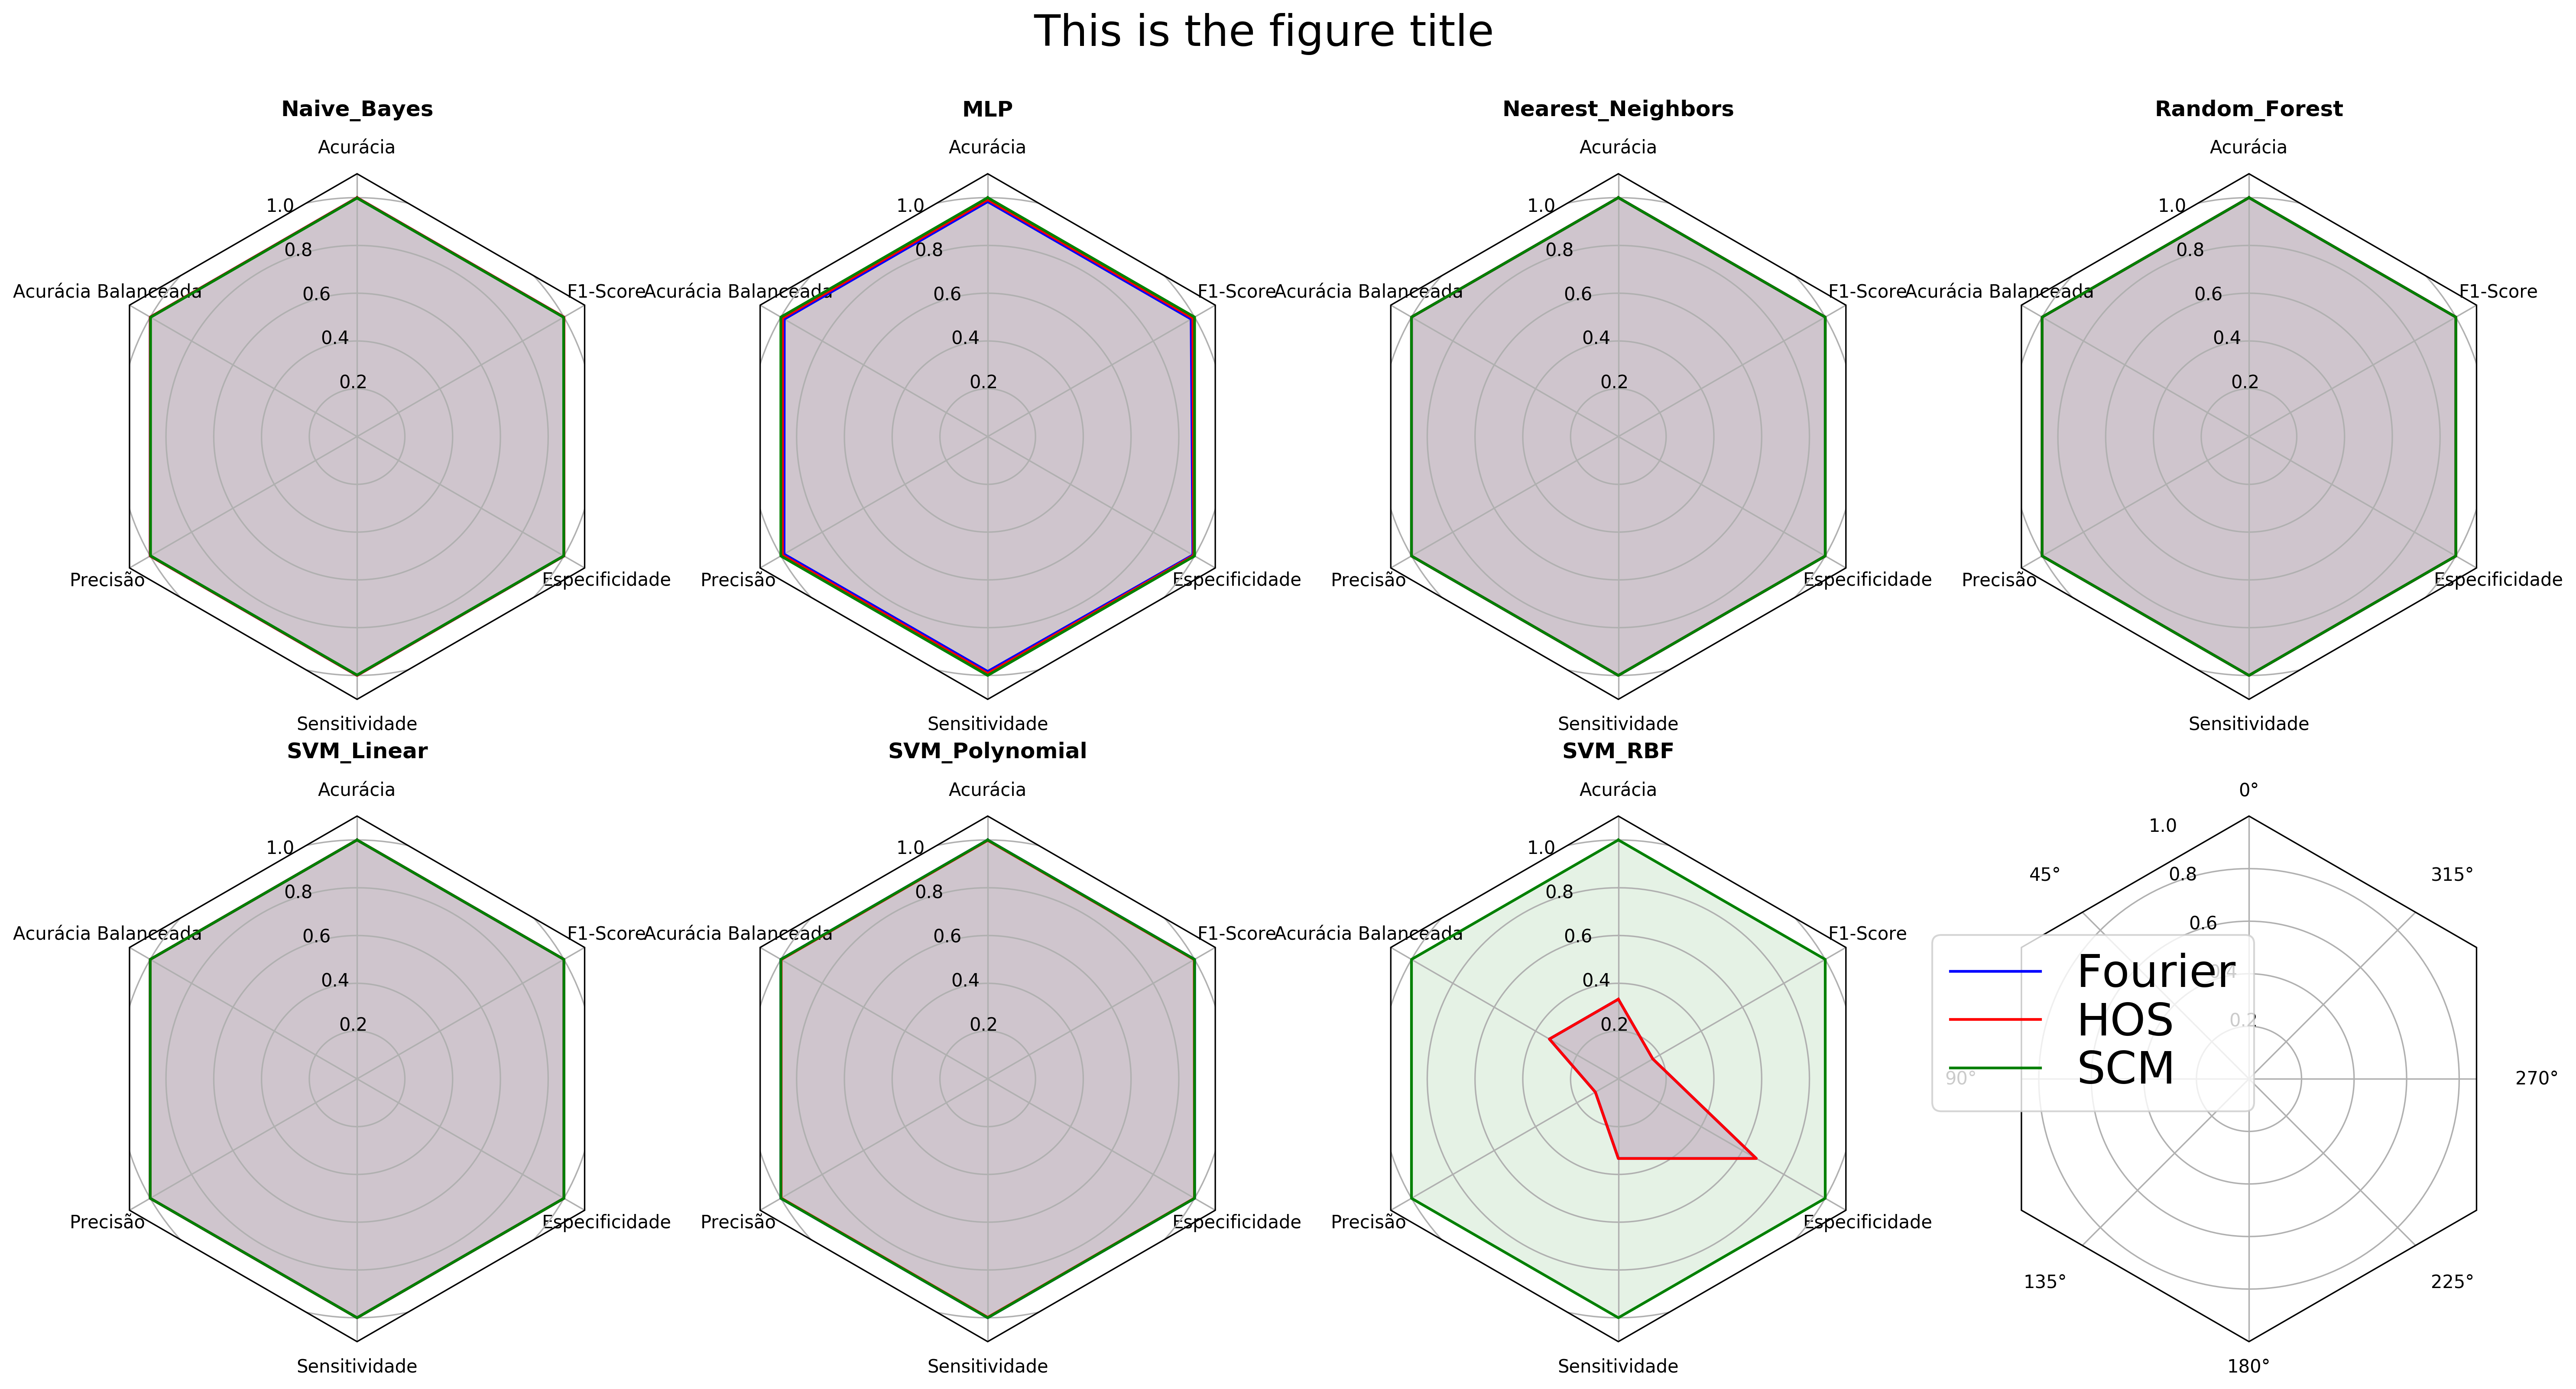

In [63]:
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

def radar_factory(num_vars, frame='circle'):
    """Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle' | 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels, fontsize=10)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta


#%%
# output plot path    



# data =[['Acurácia','Acurácia Balanceada','Precisão','Sensitividade','Especificidade','F1-Score']]

# data.append(('', mean_list))
# for j in data:
#     print(len(j))


if __name__ == '__main__':
    
    EXPERIMENT_NAME = "Frequency_Classification"
    outpath = path.join("..","results","classification",EXPERIMENT_NAME)

    # Classifier to plot:
    classifiers_name_list = ['Naive_Bayes','MLP','Nearest_Neighbors','Random_Forest','SVM_Linear','SVM_Polynomial','SVM_RBF']
    metrics_list = ['accuracy_mean','balanced_accuracy_mean','precision_mean','sensitivity_mean','specificity_mean',
                    'f1_score_mean']

    mean_classifiers_list = []
    for classifier in classifiers_name_list:
        mean_list = []
        for dataset in datasets_name_list:
            plot_csv = pd.read_csv(path.join(outpath, dataset,"evaluation_metrics.csv"), sep=',', index_col=0)
            plot_csv.drop(columns=['fit_time_mean','fit_time_std','predict_time_mean',
                                   'predict_time_std'], inplace=True) # Exclude time columns
            ds_means = list(plot_csv.loc[classifier, metrics_list])
            mean_list.append(ds_means)
        mean_classifiers_list.append(mean_list)
        
    N = 6 # metrics number
    theta = radar_factory(N, frame='polygon')

    spoke_labels = ['Acurácia','Acurácia Balanceada','Precisão','Sensitividade','Especificidade','F1-Score']

    fig, axes = plt.subplots(figsize=(24, 12), nrows=2, ncols=4, subplot_kw=dict(projection='radar'), dpi=300)   

    colors = ['b', 'r', 'g']
    
    # Plot the four cases from the example data on separate axes
    
    i = 0
    for row in range(2):
        for col in range(4):
            if row != 1 or col != 3:
                title = classifiers_name_list[i]
                case_data = mean_classifiers_list[i]

                axes[row,col].set_ylim(0, 1.1)
                axes[row,col].tick_params(axis='y',which='major',direction='out',length=4,width=4,color='b',
                                          pad=20,labelsize=10)
                axes[row,col].set_title(title, weight='bold', size='large', position=(0.5, 1.1),
                                 horizontalalignment='center', verticalalignment='center')
                
                
                for d, color in zip(case_data, colors):
                    axes[row,col].plot(theta, d, color=color)
                    axes[row,col].fill(theta, d, facecolor=color, alpha=0.10)
                    
                axes[row,col].set_varlabels(spoke_labels)
                i += 1
            else:
                axes[row,col].cla
    
    fig.suptitle('This is the figure title', fontsize=24)
    labels = ('Fourier', 'HOS', 'SCM')
    fig.legend(labels, loc=(0.75, .2),labelspacing=0.1, fontsize=25)
    
    plt.savefig(path.join(outpath, classifier+'_radar_plot.png'))
    plt.show()